In [1]:
import pickle
from scipy.interpolate import interp1d
import numpy as np
import csv
import os

from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import chi2
from scipy.stats import gennorm

## directory to read pkl data and save csv table

In [2]:
ff = "data_revision1/coverage_95/pkl/"

In [3]:
dist = "gamma" # "gennorm" "gamma" "uniform" "chisq" "gaussian"
n = 1000 # 10000 # 100 1000

In [4]:
already_read_pkl_file = False

for _,_,files in os.walk(ff):
    for my_file in files:
        if my_file.endswith(".pkl") and ("_" + str(n) + "_" in my_file) and (dist in my_file):
            with open(ff + my_file,"rb") as file_obj:
                pkl_obj = pickle.load(file_obj, encoding='latin1')
                already_read_pkl_file = True
                break
                
    if already_read_pkl_file:
        break

if not already_read_pkl_file:
    print("file does not exist!")

## compute coverage and width

In [7]:
df = 3
coverage_1 = [] #at design points
coverage_2 = [] #sec 2.4 interpolation, at design points and extended points
coverage_3 = [] #linearly interpolated upper bound, at grid points
coverage_4 = [] #sec 2.4 iterpolation, at grid points.

ave_first_quartile_width = []
ave_median_width = []
ave_third_quartile_width = []

run_time = []

for repeat in range(1000):
    if not dist + str(repeat) + "_design_pts" in pkl_obj:
#         print("missing", repeat)
        continue
    design_pts = pkl_obj[dist + str(repeat) + "_design_pts"]
    num_design_pts = len(design_pts)
    opt_pts = pkl_obj[dist + str(repeat) + "_opt_design_pts"]
    # hi at design points
    hi_opt_pts = pkl_obj[dist + str(repeat) + "_hi"]
    # lo at design points
    lo_opt_pts = pkl_obj[dist + str(repeat) + "_lo"]
#     improved_lo_opt_pts = stuff[dist + str(repeat) + "_improved_lo"]
    extended_x = pkl_obj[dist + str(repeat) + "_extended_x"]
    # hi at extended points
    improved_lo_extended_pts = pkl_obj[dist + str(repeat) + "_extended_lo"]
    # lo at extended points
    improved_hi_extended_pts = pkl_obj[dist + str(repeat) + "_extended_hi"]
    
    #################################################################################compute width
    first_sample_quartile = design_pts[num_design_pts // 4]
    sample_median = design_pts[num_design_pts // 2]
    third_sample_quartile = design_pts[int(num_design_pts // 4 * 3)]
    first_quartile_idx_in_opt_pts = np.argmin(np.abs(opt_pts - first_sample_quartile))
    median_idx_in_opt_pts = np.argmin(np.abs(opt_pts - sample_median))
    third_quartile_idx_in_opt_pts = np.argmin(np.abs(opt_pts - third_sample_quartile))
    #the bucket
    separate_point_12 = (opt_pts[first_quartile_idx_in_opt_pts] + opt_pts[median_idx_in_opt_pts]) / 2
    separate_point_23 = (opt_pts[third_quartile_idx_in_opt_pts] + opt_pts[median_idx_in_opt_pts]) / 2
    w1 = np.mean(hi_opt_pts[opt_pts <= separate_point_12] - lo_opt_pts[opt_pts <= separate_point_12])
    w3 = np.mean(hi_opt_pts[opt_pts >= separate_point_23] - lo_opt_pts[opt_pts >= separate_point_23])
    w2 = np.mean(hi_opt_pts[np.multiply(opt_pts >= separate_point_12, opt_pts <= separate_point_23)] 
                 - lo_opt_pts[np.multiply(opt_pts >= separate_point_12, opt_pts <= separate_point_23)])
    ave_first_quartile_width.append(w1)
    ave_median_width.append(w2)
    ave_third_quartile_width.append(w3)
    
    ###############################################################################compute coverage
    x_grid = np.linspace(np.min(opt_pts), np.max(opt_pts), num=10000, endpoint=True)
    if dist == "uniform":
        f_opt_pts = 1.0/20 * np.ones(len(opt_pts))
        f_ext_pts = 1.0/20 * np.ones(len(extended_x))
        f_grid = 1.0/20 * np.ones(len(x_grid))
    elif dist == "gaussian":
        f_opt_pts = norm.pdf(opt_pts)
        f_ext_pts = norm.pdf(extended_x)
        f_grid = norm.pdf(x_grid)
    elif dist == "gamma":
        f_opt_pts = gamma.pdf(opt_pts, 1.0)
        f_ext_pts = gamma.pdf(extended_x, 1.0)
        f_grid = gamma.pdf(x_grid, 1.0)
    elif dist == "chisq":
        f_opt_pts = chi2.pdf(opt_pts, df)
        f_ext_pts = chi2.pdf(extended_x, df)
        f_grid = chi2.pdf(x_grid, df)
    elif (dist == "gennorm"):
        f_opt_pts = gennorm.pdf(opt_pts, beta=4)
        f_ext_pts = gennorm.pdf(extended_x, df)
        f_grid = gennorm.pdf(x_grid, df)
    else:
        print("distribution not supported")
        break
        
    if np.all(hi_opt_pts >= f_opt_pts) and np.all(lo_opt_pts <= f_opt_pts):#design points
        coverage_1.append(1)
    else:
        coverage_1.append(0)
        
    if np.all(improved_hi_extended_pts >= f_ext_pts) and np.all(improved_lo_extended_pts <= f_ext_pts):#extended points
        coverage_2.append(1)
    else:
        coverage_2.append(0)
    
    l_log_func = interp1d(opt_pts, np.log(lo_opt_pts))
    h_func = interp1d(opt_pts, hi_opt_pts)
    if np.all(h_func(x_grid) >= f_grid) and np.all(np.exp(l_log_func(x_grid)) <= f_grid):#linear upper bound; grid
        coverage_3.append(1)
    else:
        coverage_3.append(0)
        
    l_log_ext_func = interp1d(extended_x, np.log(improved_lo_extended_pts))
    h_log_ext_func = interp1d(extended_x, np.log(improved_hi_extended_pts))
    if np.all(np.exp(h_log_ext_func(x_grid)) >= f_grid) and np.all(np.exp(l_log_ext_func(x_grid)) <= f_grid):#M_i upper bound; grid
        coverage_4.append(1)
    else:
        coverage_4.append(0)
    
    run_time.append(pkl_obj[dist + str(repeat) + "_run_time"])

## print results

In [8]:
print("coverage rate 1 =", sum(coverage_1) / len(coverage_1))
print("coverage rate 2 =",sum(coverage_2) / len(coverage_2))
print("coverage rate 3 =",sum(coverage_3) / len(coverage_3))
print("coverage rate 4 =",sum(coverage_4) / len(coverage_4))

coverage rate 1 = 0.9738955823293173
coverage rate 2 = 0.9738955823293173
coverage rate 3 = 0.9738955823293173
coverage rate 4 = 0.9738955823293173


In [9]:
covered_mask = np.array(coverage_3) == 1
ave_covered_first_quartile_width = np.array(ave_first_quartile_width)[covered_mask]
ave_covered_median_width = np.array(ave_median_width)[covered_mask]
ave_covered_third_quartile_width = np.array(ave_third_quartile_width)[covered_mask]
print("ave. width first quartile =", np.mean(np.array(ave_covered_first_quartile_width)))
print("ave. width second quartile =", np.mean(np.array(ave_covered_median_width)))
print("ave. width third quartile =", np.mean(np.array(ave_covered_third_quartile_width)))

ave. width first quartile = 0.5839988284804574
ave. width second quartile = 0.278506299976823
ave. width third quartile = 0.12257403493567005


In [10]:
print("ave. runtime =", np.mean(np.array(run_time)))

ave. runtime = 140.43205112123107


## save result

In [17]:
save = True
if save:
    with open(ff + "coverage_rates_band_widths.csv", mode="a") as file_obj:
        csv_obj = csv.writer(file_obj, delimiter=",") # , quotechar='"', quoting=csv.QUOTE_MINIMAL
        csv_obj.writerow([dist, n, 
                          np.mean(np.array(coverage_1)), np.mean(np.array(coverage_2)),
                          np.mean(np.array(coverage_3)), np.mean(np.array(coverage_4)),
                          np.mean(np.array(run_time)),
                          np.mean(np.array(ave_covered_first_quartile_width)),
                          np.mean(np.array(ave_covered_median_width)),
                          np.mean(np.array(ave_covered_third_quartile_width))
                          ])
        file_obj.close()

## plot histogram

In [12]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

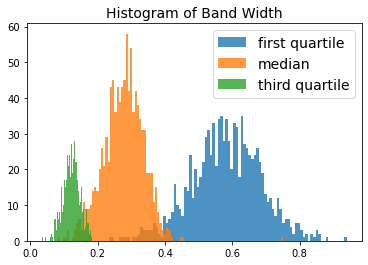

In [13]:
plt.hist(ave_first_quartile_width, label="first quartile", alpha=0.8, bins=100)
plt.hist(ave_median_width, label="median", alpha=0.8, bins=100)
plt.hist(ave_third_quartile_width, label="third quartile", alpha=0.8, bins=100)
plt.title("Histogram of Band Width", fontsize=14)
plt.legend(fontsize=14)

Text(0.5, 1.0, 'Histogram of Run Time')

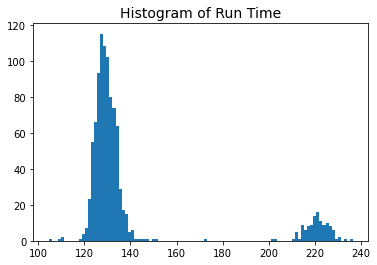

In [14]:
plt.hist(run_time, bins=100)
plt.title("Histogram of Run Time", fontsize=14)

In [15]:
# All done.